In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
import load_data

df = load_data.load_county_level()
outcome_cases = load_data.outcome_cases
outcome_deaths = load_data.outcome_deaths
df, df_test = load_data.split_data(df)

print(df.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading county level data...


/accounts/projects/vision/chandan/covid-19-geographic-risk-prediction/functions/merge_data.py:40: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  diabetes.columns = ["countyFIPS", "DiabetesPercentage"]


ks Index(['countyFIPS', 'Respiratory Mortality'], dtype='object')
Index(['id', 'Header-FIPSStandCtyCode', 'EntityofFile',
       'SecondaryEntityOfFile', 'DateofFile', 'DateofCreation', 'FileLength',
       'StateName', 'StateNameAbbreviation', 'CountyName',
       ...
       'DiabetesPercentage', 'Respiratory Mortality', 'dem_to_rep_ratio',
       '#Hospitals', '#ICU_beds', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'FracMale2017', '#FTEHospitalTotal2017'],
      dtype='object', length=7305)


## how many deaths/cases are there

In [11]:
df[[outcome_deaths, outcome_cases, 'StateName', 'CountyName', ]].head(10)

,#Deaths_3/22/2020,#Cases_3/22/2020,StateName,CountyName
1064,75,1040,Washington,King
695,60,9045,New York,New York
92,10,302,California,Santa Clara
643,7,457,New Jersey,Bergen
82,6,45,California,Riverside
269,6,805,Illinois,Cook
71,5,409,California,Los Angeles
506,5,477,Michigan,Wayne
709,4,1034,New York,Suffolk
694,4,1900,New York,Nassau


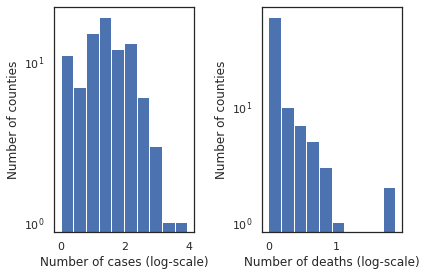

In [12]:
d = df[df[outcome_deaths] > 0]
R, C = 1, 2
plt.subplot(R, C, 1)
plt.hist(np.log10(d[outcome_cases]))
plt.xlabel('Number of cases (log-scale)')
plt.ylabel('Number of counties')
plt.yscale('log')

plt.subplot(R, C, 2)
plt.hist(np.log10(d[outcome_deaths]))
plt.xlabel('Number of deaths (log-scale)')
plt.ylabel('Number of counties')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [13]:
demographics = ['PopulationEstimate2018', 'Population(Persons)2017',  
                'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
                'PopulationEstimate65+2017',
                'PopulationDensityperSqMile2010',
                'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010']

# hospital vars
hospitals_hrsa = ['#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017']
hospitals_misc = ["#Hospitals", "#ICU_beds"]
hospitals = hospitals_hrsa + hospitals_misc

# comorbidity (simultaneous presence of multiple conditions) vars
comorbidity_hrsa = [ '#EligibleforMedicare2018',  'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17']
comorbidity_misc = ["DiabetesPercentage", "HeartDiseaseMortality", "StrokeMortality", "Smokers_Percentage"]
comorbidity = comorbidity_hrsa + comorbidity_misc

# political leanings (ratio of democrat : republican votes in 2016 presidential election)
political = ['dem_to_rep_ratio']

important_vars = demographics + comorbidity + hospitals + political

# correlations

In [ ]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df[important_vars + [outcome_cases, outcome_deaths]]

# Compute the correlation matrix
corrs = d.corr(method='spearman')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(corrs, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig('results/correlations_heatmap.png')
plt.show()

In [ ]:
keys = np.array(corrs.index)
k = np.where(keys == outcome_deaths)[0][0]
corrs_row = corrs.iloc[k]
args = np.argsort(corrs_row)
plt.figure(dpi=300, figsize=(6, 5))
plt.barh(keys[args][:-1], corrs_row[args][:-1]) # 1 to drop outcome itself
plt.xlabel('Correlation (spearman) with # deaths')
plt.tight_layout()
plt.savefig('results/correlations.png')
plt.show()

# interactive plots

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz.plot_counties(d, 
                          variable_to_distribute=outcome_cases,
                          variables_to_display=important_vars,
                          state=state,
                          logcolor=False)
    
    output_file(f"results/{state}.html", mode='inline')
    show(p)
    save(p)

In [ ]:
sorted(list([k for k in df.keys() if '' in k.lower()]))

## plot political leaning

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz.plot_counties(d, 
                          variable_to_distribute='dem_to_rep_ratio',
                          variables_to_display=important_vars,
                          state=state,
                          logcolor=False)
    show(p)